# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name:*Syma Afsha*  
**Neptun ID:*DGLTNJ*

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

Split your dataset into train, val and test sets

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

Example output from dataset class

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
import pandas as pd
import spacy
from collections import Counter
from PIL import Image

# Load English tokenizer from spaCy
spacy_eng = spacy.load("en_core_web_sm")


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        """
        Initialize the dataset with images and captions, and create the vocabulary.
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.images = self.df['image']
        self.captions = self.df['caption']
        self.freq_threshold = freq_threshold
        
        # Initialize vocabulary
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index_to_vocab = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        
        # Build vocabulary
        self.build_vocabulary(self.captions.tolist())
        
        # Vectorize captions
        self.caption_vector = self.vectorize_caption()

    def build_vocabulary(self, sentence_list):
        """
        Build the vocabulary from the captions based on word frequency.
        """
        frequencies = Counter()

        # Count word frequencies across all captions
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

        # Add words that appear more than the frequency threshold
        idx = 4
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                self.index_to_vocab[idx] = word  # Reverse mapping
                idx += 1

    def tokenize(self, text):
        """
        Tokenize the text using spaCy.
        """
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text) if tok.is_alpha]

    def vectorize_caption(self):
        """
        Convert the captions into numerical format using the vocabulary.
        """
        caption_vector = []
        for caption in self.captions:
            caption_vec = [self.stoi["<SOS>"]] + \
                          self.numericalize(caption) + \
                          [self.stoi["<EOS>"]]
            caption_vector.append(caption_vec)
        return caption_vector

    def numericalize(self, text):
        """
        Convert text into numerical representation based on the vocabulary.
        """
        tokenized_text = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

    def __len__(self):
        """
        Return the size of the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Get an image and its corresponding caption from the dataset.
        """
        img_id = self.images[idx]
        img_path = os.path.join(self.root_dir, img_id)

        # Load and transform the image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Numericalized caption for the current index
        caption_vec = self.caption_vector[idx]

        # All captions related to the same image
        all_captions = self.df[self.df['image'] == img_id]['caption'].tolist()
        all_caption_vectors = [
            [self.stoi["<SOS>"]] +
            self.numericalize(caption) +
            [self.stoi["<EOS>"]]
            for caption in all_captions
        ]

        return image, torch.tensor(caption_vec), all_caption_vectors


# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update the collate_fn to pass the entire vocab dictionary
def collate_fn(batch, dataset):
    """
    Custom collate function to handle variable-length captions.
    """
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    all_captions = [item[2] for item in batch]

    # Pad captions to the maximum length in the batch
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=dataset.stoi["<PAD>"])
    
    return torch.stack(images), captions_padded, all_captions





# Root directory and captions file path
root_dir = 'adityajn105/flickr8k/versions/1/Images'
captions_file = 'adityajn105/flickr8k/versions/1/captions.txt'

# Initialize dataset
dataset = FlickrDataset(root_dir=root_dir, captions_file=captions_file, transform=train_transform)

# Manually splitting dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

# Apply transformations for each split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders with the complete vocab (both stoi and itos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, dataset))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, dataset))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, dataset))

print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")


Training Set Size: 32364
Validation Set Size: 6068
Test Set Size: 2023


Token for 'pink': 7
Batch Shape - Images: torch.Size([32, 3, 224, 224]), Captions: torch.Size([32, 25])
Tokenized: [1, 4, 28, 219, 39, 418, 55, 6, 7, 36, 3, 13, 35, 36, 24, 129, 6, 126, 212, 2, 0, 0, 0, 0, 0]
Decoded: a dog jumps on bed covered in pink with of playing with the ball in its mouth
Tokenized: [1, 4, 684, 29, 548, 166, 4, 117, 250, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: a rider and horse jumping a fence outdoors
Tokenized: [1, 73, 187, 372, 183, 245, 375, 6, 24, 1777, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: young people pose for their picture in the countryside


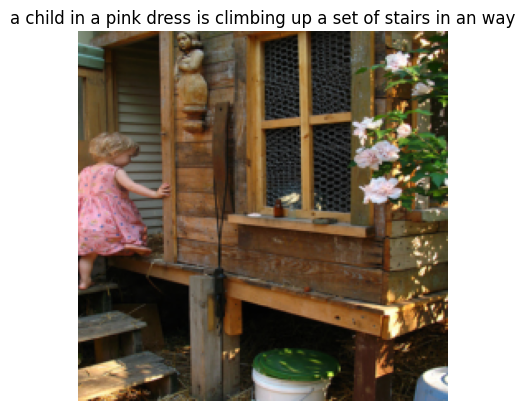

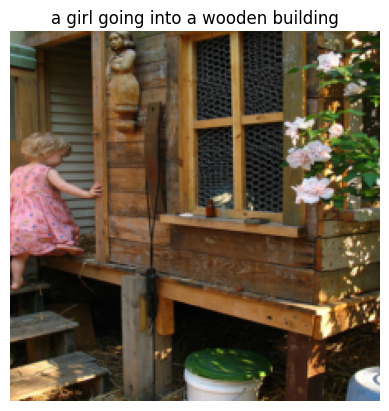

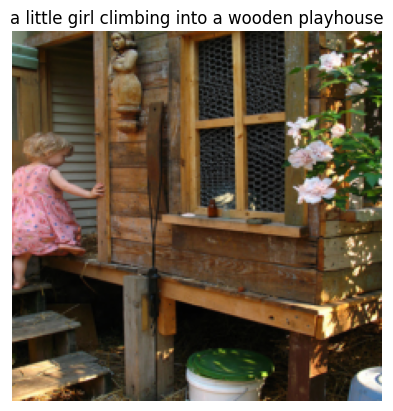

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def decode_caption_from_tokens(tokens, vocab):
    """
    Converts token IDs to their corresponding words, excluding special tokens.
    """
    return " ".join(
        [vocab.index_to_vocab[token] for token in tokens if token not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<UNK>"]}]
    )

def fetch_token_for_word(word, vocab):
    """
    Retrieve the token ID for a specific word from the vocabulary.
    """
    return vocab.stoi.get(word, vocab.stoi["<UNK>"])

# Checking the token for a specific word
word_to_check = "pink"
token_for_word = fetch_token_for_word(word_to_check, dataset)  # Use dataset directly
print(f"Token for '{word_to_check}': {token_for_word}")

# Iterate over a batch of data
for imgs, captions, _ in train_loader:
    print(f"Batch Shape - Images: {imgs.shape}, Captions: {captions.shape}")

    # Display some captions from the batch
    for i in range(3):
        tokenized_caption = captions[i].tolist()
        decoded_caption = decode_caption_from_tokens(tokenized_caption, dataset)
        print(f"Tokenized: {tokenized_caption}")
        print(f"Decoded: {decoded_caption}")
        
    break

def display_image_with_caption(img_tensor, caption_tokens, vocab, title=None):
    """
    Unnormalizes the image and shows it with a caption.
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values for proper display

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_samples_from_dataset(dataset, num_samples=3):
    """
    Displays a few random samples from the dataset with their corresponding captions.
    """
    for i in range(num_samples):
        image, caption_tensor, _ = dataset[i]
        caption_tokens = caption_tensor.tolist()  # Convert tensor to list of tokens
        caption_str = decode_caption_from_tokens(caption_tokens, dataset)  # Decode tokens

        # Get the original caption from the dataset
        original_caption = dataset.df.iloc[i]['caption']

        # Display image and captions
        display_image_with_caption(image, caption_tokens, dataset, title=caption_str)

       


# Display a few random samples
show_samples_from_dataset(dataset, num_samples=3)


#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


Combine the encoder - attention - decoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

""" FeatureExtractor: Extract features from ResNet50 backbone """
class FeatureExtractor(nn.Module):
    def __init__(self, output_dim):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and pooling layers
        self.avg_pool = nn.AdaptiveAvgPool2d((7, 7))  # Pool to 7x7 feature maps
        self.fc_layer = nn.Linear(2048, output_dim)  # Fully connected layer for embedding features
        self.relu_activation = nn.ReLU()
        self.dropout_layer = nn.Dropout(0.5)

        # Fine-tune the ResNet layers by making them trainable
        for param in self.resnet_backbone.parameters():
            param.requires_grad = True

    def forward(self, images):
        features = self.resnet_backbone(images)  # (batch_size, 2048, 7, 7)  # Extract features from the ResNet backbone
        pooled_features = self.avg_pool(features)  # (batch_size, 2048, 7, 7)  # Apply average pooling to get fixed-size feature map
        flattened_features = pooled_features.view(pooled_features.size(0), -1)  
        embedded_features = self.fc_layer(flattened_features) # Project to the desired embedding space
        return self.dropout_layer(self.relu_activation(embedded_features)) # Apply dropout and ReLU activation


""" Attention Mechanism: Focuses on relevant parts of the image """
class AttentionMechanism(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(AttentionMechanism, self).__init__()
        self.encoder_attention = nn.Linear(encoder_dim, attention_dim)  # Project encoder output to attention space
        self.decoder_attention = nn.Linear(decoder_dim, attention_dim)  # Project decoder state to attention space
        self.attention_combination = nn.Linear(attention_dim, 1)  # Combine the attention vectors 
        self.activation = nn.GELU()  #Gelu activation function
        self.softmax = nn.Softmax(dim=1) # Softmax to compute attention weights


    def forward(self, encoder_outputs, decoder_state):
   
        encoder_proj = self.encoder_attention(encoder_outputs)  # (batch_size, num_pixels, attention_dim) # Project encoder outputs to attention space
        decoder_proj = self.decoder_attention(decoder_state).unsqueeze(1)  # (batch_size, 1, attention_dim)  # Project decoder state
        combined_attention = self.attention_combination(self.activation(encoder_proj + decoder_proj)).squeeze(2)  # (batch_size, num_pixels)  # Combine and apply activation
        attention_weights = self.softmax(combined_attention)  # (batch_size, num_pixels) # Apply softmax to get attention weights

       
        # Calculate context vector as weighted sum of encoder outputs based on attention weights
        context_vector = (encoder_outputs * attention_weights.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return context_vector, attention_weights



""" Captioning Decoder: LSTM-based decoder that generates captions """

class CaptioningDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim, num_layers=2, dropout=0.5):
        super(CaptioningDecoder, self).__init__()
        self.attention = AttentionMechanism(encoder_dim, decoder_dim, attention_dim)  # Attention mechanism
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)  # Word embeddings
        self.lstm_cell = nn.LSTM(embed_size + encoder_dim, decoder_dim, num_layers, batch_first=True, dropout=dropout) # LSTM cell
        self.fc_out = nn.Linear(decoder_dim, vocab_size)  # Output layer to predict the next word
        self.layer_norm = nn.LayerNorm(decoder_dim) # Layer normalization
        self.dropout_layer = nn.Dropout(dropout) # Dropout layer

    def forward(self, encoder_outputs, captions):
        batch_size, seq_length = captions.size()
        num_pixels = encoder_outputs.size(1)

        embedded_captions = self.dropout_layer(self.embedding_layer(captions))  # (batch_size, seq_length, embed_size) # Embed captions and apply dropout
        
        hidden_state, cell_state = torch.zeros(1, batch_size, encoder_outputs.size(2)).to(captions.device), \
                                   torch.zeros(1, batch_size, encoder_outputs.size(2)).to(captions.device) 
        lstm_outputs = torch.zeros(batch_size, seq_length, self.fc_out.out_features).to(captions.device) # Store LSTM outputs

        attention_weights_per_timestep = torch.zeros(batch_size, seq_length, num_pixels).to(captions.device) # Store attention weights

        for t in range(seq_length):
            context, attention_weights = self.attention(encoder_outputs, hidden_state[-1]) # Compute context vector using attention mechanism
            attention_weights_per_timestep[:, t, :] = attention_weights # Store attention weights

            lstm_input = torch.cat([embedded_captions[:, t, :], context], dim=1).unsqueeze(1)  # Concatenate embedded caption with context vector
            _, (hidden_state, cell_state) = self.lstm_cell(lstm_input, (hidden_state, cell_state)) # LSTM forward pass
            hidden_state = self.layer_norm(hidden_state[-1])  # Apply LayerNorm to LSTM hidden state
            lstm_outputs[:, t, :] = self.fc_out(hidden_state)  # Predict the next word in the sequence

        return lstm_outputs, attention_weights_per_timestep


""" Complete Image Captioning Model: Combines feature extraction and caption generation """
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim):
        super(ImageCaptioningModel, self).__init__()
        self.feature_extractor = FeatureExtractor(embed_size) # Feature extractor from ResNet50
        self.caption_decoder = CaptioningDecoder(embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim) # Caption generation decoder
  # Embed captions and apply dropout
    def forward(self, images, captions):
        extracted_features = self.feature_extractor(images)   # Get image features from FeatureExtractor
        caption_predictions, attention_weights = self.caption_decoder(extracted_features, captions)  # Generate captions
        return caption_predictions, attention_weights


In [ ]:
import torch
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model parameters
embed_size = 256
encoder_dim = 256
decoder_dim = 256
attention_dim = 128
vocab_size = len(dataset.stoi)
# Initialize the model
model = ImageCaptioningModel(embed_size, vocab_size, encoder_dim, decoder_dim, attention_dim).to(device)

# Create a random batch of images and captions for testing
batch_size = 32
seq_length = 30  # This is the maximum caption length

# Sample input data
images = torch.randn(batch_size, 3, 224, 224).to(device)  # Random images
captions = torch.randint(0, vocab_size, (batch_size, seq_length)).to(device)  # Random captions

# Forward pass through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs, attention_weights = model(images, captions)

# Print the output shapes
print("Images shape:", images.shape)                # Expected: (batch_size, 3, 224, 224)
print("Captions shape:", captions.shape)            # Expected: (batch_size, seq_length)
print("Outputs shape:", outputs.shape)              # Expected: (batch_size, seq_length, vocab_size)
print("Attention weights shape:", attention_weights.shape)  # Expected: (batch_size, seq_length, num_pixels)


Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 30])
Outputs shape: torch.Size([32, 30, 2974])
Attention weights shape: torch.Size([32, 30, 49])


### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

Epoch 1/50: 100%|██████████| 1012/1012 [07:19<00:00,  2.30batch/s]


Epoch [1/50] - Training Loss: 4.9911


Epoch [1/50] - Validation Loss: 4.3984
New best model saved with validation loss: 4.3984


Epoch 2/50: 100%|██████████| 1012/1012 [07:02<00:00,  2.40batch/s]


Epoch [2/50] - Training Loss: 4.1754


Epoch [2/50] - Validation Loss: 3.9619
New best model saved with validation loss: 3.9619


Epoch 3/50: 100%|██████████| 1012/1012 [07:03<00:00,  2.39batch/s]


Epoch [3/50] - Training Loss: 3.8464


Epoch [3/50] - Validation Loss: 3.7366
New best model saved with validation loss: 3.7366


Epoch 4/50: 100%|██████████| 1012/1012 [07:08<00:00,  2.36batch/s]


Epoch [4/50] - Training Loss: 3.6255


Epoch [4/50] - Validation Loss: 3.5859
New best model saved with validation loss: 3.5859


Epoch 5/50: 100%|██████████| 1012/1012 [07:02<00:00,  2.40batch/s]


Epoch [5/50] - Training Loss: 3.4596


Epoch [5/50] - Validation Loss: 3.4789
New best model saved with validation loss: 3.4789


Epoch 6/50: 100%|██████████| 1012/1012 [07:05<00:00,  2.38batch/s]


Epoch [6/50] - Training Loss: 3.3298


Epoch [6/50] - Validation Loss: 3.3923
New best model saved with validation loss: 3.3923


Epoch 7/50: 100%|██████████| 1012/1012 [07:06<00:00,  2.37batch/s]


Epoch [7/50] - Training Loss: 3.2209


Epoch [7/50] - Validation Loss: 3.3351
New best model saved with validation loss: 3.3351


Epoch 8/50: 100%|██████████| 1012/1012 [07:02<00:00,  2.40batch/s]


Epoch [8/50] - Training Loss: 3.1273


Epoch [8/50] - Validation Loss: 3.2768
New best model saved with validation loss: 3.2768


Epoch 9/50: 100%|██████████| 1012/1012 [07:03<00:00,  2.39batch/s]


Epoch [9/50] - Training Loss: 3.0460


Epoch [9/50] - Validation Loss: 3.2342
New best model saved with validation loss: 3.2342


Epoch 10/50: 100%|██████████| 1012/1012 [07:05<00:00,  2.38batch/s]


Epoch [10/50] - Training Loss: 2.9748


Epoch [10/50] - Validation Loss: 3.1988
New best model saved with validation loss: 3.1988


Epoch 11/50: 100%|██████████| 1012/1012 [07:03<00:00,  2.39batch/s]


Epoch [11/50] - Training Loss: 2.9093


Epoch [11/50] - Validation Loss: 3.1846
New best model saved with validation loss: 3.1846


Epoch 12/50: 100%|██████████| 1012/1012 [07:07<00:00,  2.37batch/s]


Epoch [12/50] - Training Loss: 2.8489


Epoch [12/50] - Validation Loss: 3.1582
New best model saved with validation loss: 3.1582


Epoch 13/50: 100%|██████████| 1012/1012 [07:04<00:00,  2.39batch/s]


Epoch [13/50] - Training Loss: 2.7966


Epoch [13/50] - Validation Loss: 3.1289
New best model saved with validation loss: 3.1289


Epoch 14/50: 100%|██████████| 1012/1012 [07:02<00:00,  2.39batch/s]


Epoch [14/50] - Training Loss: 2.7481


Epoch [14/50] - Validation Loss: 3.1168
New best model saved with validation loss: 3.1168


Epoch 15/50: 100%|██████████| 1012/1012 [07:00<00:00,  2.41batch/s]


Epoch [15/50] - Training Loss: 2.7030


Epoch [15/50] - Validation Loss: 3.0940
New best model saved with validation loss: 3.0940


Epoch 16/50: 100%|██████████| 1012/1012 [07:04<00:00,  2.38batch/s]


Epoch [16/50] - Training Loss: 2.6594


Epoch [16/50] - Validation Loss: 3.0903
No significant improvement in validation loss for 1 epochs. Improvement: 0.0036


Epoch 17/50: 100%|██████████| 1012/1012 [07:04<00:00,  2.38batch/s]


Epoch [17/50] - Training Loss: 2.6202


Epoch [17/50] - Validation Loss: 3.0805
New best model saved with validation loss: 3.0805


Epoch 18/50: 100%|██████████| 1012/1012 [06:52<00:00,  2.45batch/s]


Epoch [18/50] - Training Loss: 2.5794


Epoch [18/50] - Validation Loss: 3.0829
No significant improvement in validation loss for 1 epochs. Improvement: -0.0024


Epoch 19/50: 100%|██████████| 1012/1012 [07:09<00:00,  2.36batch/s]


Epoch [19/50] - Training Loss: 2.5461


Epoch [19/50] - Validation Loss: 3.0625
New best model saved with validation loss: 3.0625


Epoch 20/50: 100%|██████████| 1012/1012 [07:09<00:00,  2.36batch/s]


Epoch [20/50] - Training Loss: 2.5093


Epoch [20/50] - Validation Loss: 3.0806
No significant improvement in validation loss for 1 epochs. Improvement: -0.0182


Epoch 21/50: 100%|██████████| 1012/1012 [07:05<00:00,  2.38batch/s]


Epoch [21/50] - Training Loss: 2.4781


Epoch [21/50] - Validation Loss: 3.0639
No significant improvement in validation loss for 2 epochs. Improvement: -0.0014


Epoch 22/50: 100%|██████████| 1012/1012 [07:04<00:00,  2.38batch/s]


Epoch [22/50] - Training Loss: 2.4471


Epoch [22/50] - Validation Loss: 3.0602
No significant improvement in validation loss for 3 epochs. Improvement: 0.0023
Early stopping triggered.


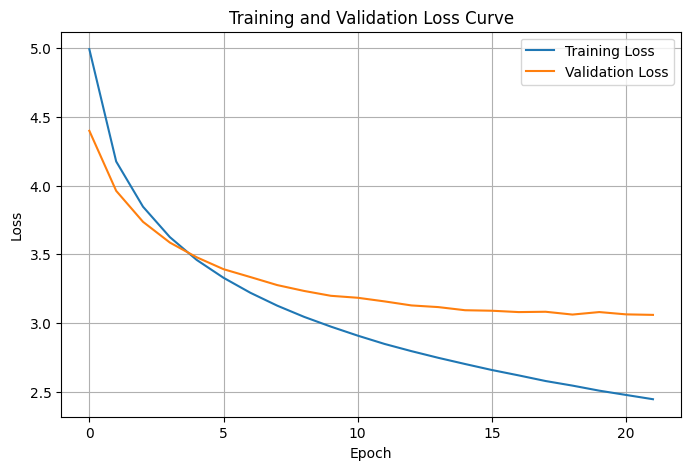

In [31]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters and configurations
config = {
    "embed_size": 256,
    "encoder_dim": 256,
    "decoder_dim": 256,
    "attention_dim": 128,
    "learning_rate": 1e-4,
    "num_epochs": 50,
    "batch_size": 32,
    "checkpoint_path": "Syma_test.pth",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "patience": 3,
    "min_delta": 0.01  # Minimum improvement for early stopping
}

# Vocab size from the dataset
vocab_size = len(dataset.stoi)  # Adjusted for the FlickrDataset
checkpoint_path = config["checkpoint_path"]
best_model_path = "Final_model_Syma.pth"

# Initialize model, optimizer, and loss function
model = ImageCaptioningModel(config["embed_size"], vocab_size, config["encoder_dim"], 
                             config["decoder_dim"], config["attention_dim"]).to(config["device"])

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.stoi["<PAD>"])

# Create directories for checkpoints if not exist
os.makedirs('checkpoints', exist_ok=True)

# Load checkpoint if available
start_epoch = 0
loss_list = []
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_list = checkpoint['loss_list']
    print(f"Resuming training from epoch {start_epoch}")

# Function to perform validation
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():
        # Progress bar for validation
        for images, captions, _ in tqdm(val_loader, desc="Validating", unit="batch", leave=False):
            images, captions = images.to(device), captions.to(device)

            # Forward pass
            outputs, _ = model(images, captions[:, :-1])
            
            # Compute loss
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

# Function for training with early stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, config):
    train_loss_list = []
    val_loss_list = []

    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0

        # Training loop with progress bar
        for images, captions, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, captions = images.to(config["device"]), captions.to(config["device"])

            optimizer.zero_grad()

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs, _ = model(images, captions[:, :-1])
                loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f}")

        # Validation step
        avg_val_loss = validate_model(model, val_loader, criterion, config["device"])
        val_loss_list.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.4f}")

        # Early stopping based on validation loss
        improvement = best_val_loss - avg_val_loss
        if improvement > config["min_delta"]:
            best_val_loss = avg_val_loss
            # Save only the best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_list': train_loss_list
            }, best_model_path)
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
            early_stop_counter = 0  # Reset early stopping counter
        else:
            early_stop_counter += 1
            print(f"No significant improvement in validation loss for {early_stop_counter} epochs. Improvement: {improvement:.4f}")

        # Trigger early stopping if no significant improvement after patience
        if early_stop_counter >= config["patience"]:
            print("Early stopping triggered.")
            break

        # Save checkpoint at every epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_list': train_loss_list
        }, checkpoint_path)

    return train_loss_list, val_loss_list

# Start training the model
train_loss_list, val_loss_list = train_model(model, train_loader, val_loader, optimizer, criterion, 
                                              config["num_epochs"], config)

# Plotting the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
def generate_caption(model, image, vocab, device, max_length=20):
    """
    Generate a caption for an image using the trained model with attention visualization.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device
    
    # Check if 'itos' exists in vocab, if not, create it from 'stoi'
    if "itos" not in vocab:
        vocab["itos"] = {v: k for k, v in vocab["stoi"].items()}  # Create reverse mapping

    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Extract features using the feature extractor
        extracted_features = model.feature_extractor(image)  # (batch_size, 49, embed_size)
        
        # Initialize caption (starting with <SOS> token)
        caption = [vocab["stoi"]["<SOS>"]]  # Use stoi directly
        attention_weights = []

        # Initialize hidden and cell states for the LSTM
        h, c = torch.zeros(1, 1, extracted_features.size(2)).to(device), torch.zeros(1, 1, extracted_features.size(2)).to(device)

        for t in range(max_length):
            # Prepare the input for the decoder
            input_caption = torch.tensor([caption[-1]]).unsqueeze(0).to(device)  # Shape: (1, 1)
            embedded_caption = model.caption_decoder.embedding_layer(input_caption)  # Shape: (1, 1, embed_size)

            # Compute attention and context vector using the caption_decoder
            context, alpha = model.caption_decoder.attention(extracted_features, h[-1])  # (1, encoder_dim), (1, num_pixels)
            attention_weights.append(alpha.squeeze(0))  # Append attention weights

            # Concatenate embeddings and context for LSTM input
            lstm_input = torch.cat([embedded_caption.squeeze(1), context], dim=1).unsqueeze(0)  # Shape: (1, 1, embed_size + encoder_dim)

            # Pass through LSTM
            _, (h, c) = model.caption_decoder.lstm_cell(lstm_input, (h, c))

            # Generate output predictions
            outputs = model.caption_decoder.fc_out(h[-1])  # Shape: (1, vocab_size)
            predicted_word_idx = outputs.argmax(dim=1).item()

            # Append the predicted word to the caption
            caption.append(predicted_word_idx)
            if predicted_word_idx == vocab["stoi"]["<EOS>"]:  # Use stoi directly
                break

        attention_weights = torch.stack(attention_weights, dim=0)  # Combine attention weights
        decoded_caption = [vocab["itos"][idx] for idx in caption]  # Use itos for converting indices to words
        return decoded_caption, attention_weights


In [14]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

def visualize_attention_weights(input_image, caption_words, attention_maps):
    """
    Visualize attention maps by overlaying them on the input image for each word in the caption.
    
    Args:
        input_image: Tensor of shape (3, H, W), the input image to visualize.
        caption_words: List of strings representing the caption words.
        attention_maps: Tensor of shape (seq_length, num_pixels), attention weights corresponding to each word.
    """
    # Preprocess the image for visualization
    input_image = input_image.cpu().numpy().transpose(1, 2, 0)  # (H, W, C)
    input_image = (input_image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # De-normalize
    input_image = np.clip(input_image, 0, 1)  # Clip to valid range [0, 1]

    # Get attention map dimensions
    seq_length, num_pixels = attention_maps.shape
    grid_size = int(math.sqrt(num_pixels))  # Calculate the grid size based on num_pixels

    # Reshape attention maps into a 2D grid for visualization
    attention_maps = attention_maps.view(seq_length, grid_size, grid_size)  # Reshape to (seq_length, 7, 7)

    # Resize attention maps to match image dimensions (224x224)
    resized_attention_maps = []
    for map in attention_maps:
        resized_map = F.interpolate(map.unsqueeze(0).unsqueeze(0), size=(input_image.shape[0], input_image.shape[1]), mode='bilinear', align_corners=False)
        resized_attention_maps.append(resized_map.squeeze().cpu().detach().numpy())

    # Calculate number of rows and columns for the subplot grid
    num_columns = min(5, seq_length)  # Try to fit in a reasonable number of columns
    num_rows = math.ceil(seq_length / num_columns)  # Automatically calculate the number of rows

    # Create a figure for visualization
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 5, num_rows * 5))  # Adjust figure size for larger images
    axes = axes.flatten()  # Flatten axes for easier indexing

    for t, ax in enumerate(axes):
        if t < seq_length:
            # Overlay the attention map on the image
            ax.imshow(input_image)  # Display the original image
            ax.imshow(resized_attention_maps[t], cmap='jet', alpha=0.6)  # Overlay attention map with transparency
            ax.set_title(caption_words[t], fontsize=12)  # Title with the word from the caption
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off any extra subplot

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase spacing to reduce overlap
    plt.show()


In [5]:
import torch


# Load the saved model
checkpoint_path = "Final_model_Syma.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Restore the model and optimizer
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


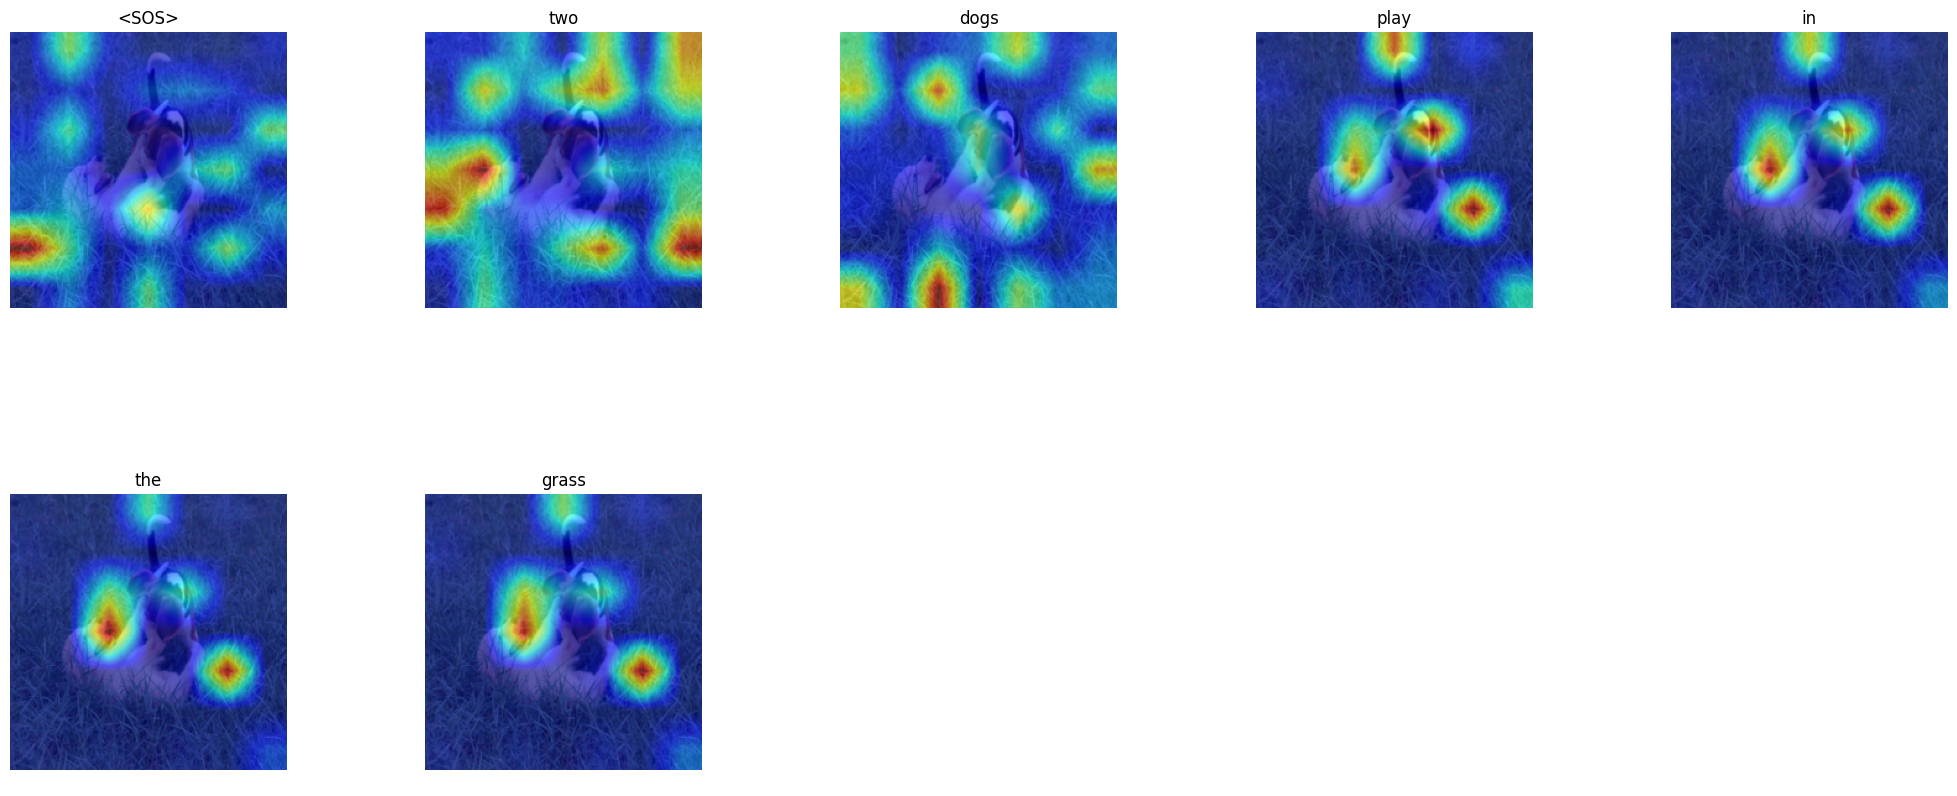

In [16]:
# Load a single image and preprocess
image_path = "adityajn105/flickr8k/versions/1/Images/23445819_3a458716c1.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Generate caption and attention weights
# Example usage:
vocab = dataset.__dict__  # This will give you access to both stoi and itos
decoded_caption, attention_weights = generate_caption(model, image_tensor, vocab, device)



# Visualize attention
visualize_attention_weights(image_tensor, decoded_caption, attention_weights)


### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [19]:
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

def evaluate_bleu_scores(captioning_model, test_data_loader, vocabulary, device, max_caption_length=30):
    """
    Evaluates BLEU scores (BLEU-1, BLEU-2, BLEU-3) for the model on the test dataset.

    Args:
        captioning_model: Trained image captioning model.
        test_data_loader: DataLoader for the test dataset.
        vocabulary: Vocabulary used in the dataset, containing both stoi and itos.
        device: Device to run the evaluation on ('cuda' or 'cpu').
        max_caption_length: Maximum caption length for generation.

    Returns:
        Dictionary of BLEU scores.
    """
    captioning_model.eval()  # Set model to evaluation mode
    reference_captions = []
    generated_captions = []

    with torch.no_grad():
        for images, target_captions, all_captions in tqdm(test_data_loader, desc="Calculating BLEU"):
            images = images.to(device)

            # Generate captions for all images in the batch
            batch_generated_captions = []
            for img in images:
                # Generate caption for each image
                caption, _ = generate_caption(captioning_model, img, vocabulary, max_length=max_caption_length, device=device)
                batch_generated_captions.append(caption)

            # Process captions and prepare references and hypotheses
            for i in range(len(target_captions)):
                # Reference captions (ground truth), could be multiple
                reference = []
                for target_caption in all_captions[i]:  # This handles all captions for the i-th image
                    reference_caption = [
                        vocabulary["itos"][token] for token in target_caption
                        if token not in [vocabulary["stoi"]["<PAD>"], vocabulary["stoi"]["<SOS>"], vocabulary["stoi"]["<EOS>"]]
                    ]
                    if len(reference_caption) > 0:
                        reference.append(reference_caption)  # Add valid reference caption

                # Generated caption (hypothesis)
                hypothesis = [word for word in batch_generated_captions[i] if word not in ['<PAD>', '<SOS>', '<EOS>']]

                # Append if both reference and hypothesis are valid
                if len(hypothesis) > 0 and len(reference) > 0:
                    reference_captions.append(reference)
                    generated_captions.append(hypothesis)

    # Calculate BLEU scores
    bleu1 = bleu_score(generated_captions, reference_captions, max_n=1, weights=[1.0])
    bleu2 = bleu_score(generated_captions, reference_captions, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(generated_captions, reference_captions, max_n=3, weights=[1/3, 1/3, 1/3])

    return {"BLEU-1": bleu1, "BLEU-2": bleu2, "BLEU-3": bleu3}

# Ensure vocabulary is correctly passed
vocabulary = dataset.__dict__  # Pass the entire vocab dictionary with stoi and itos

# Run BLEU evaluation
bleu_scores = evaluate_bleu_scores(model, test_loader, vocabulary, device)
print("BLEU Scores:", bleu_scores)


Calculating BLEU: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]


BLEU Scores: {'BLEU-1': 0.5479488372802734, 'BLEU-2': 0.3624468147754669, 'BLEU-3': 0.22993753850460052}


### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

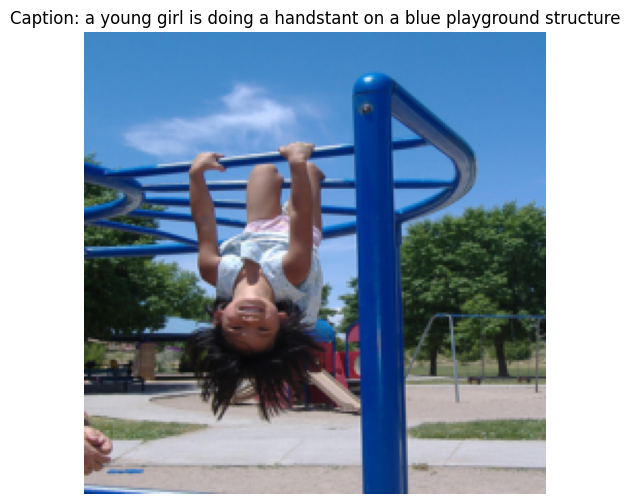

In [22]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BLIP model and processor
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
Blip_model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

# Function to generate captions using BLIP
def generate_caption_blip(image, max_length=30):
    """
    Generates a caption for a single image using the BLIP model.

    Args:
        image: Normalized image tensor with shape (3, H, W).
        max_length: Maximum length of the generated caption.

    Returns:
        Generated caption as a list of words.
    """
    # De-normalize the image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image.device)
    image = image * std + mean  # De-normalize the image to range [0, 1]
    
    # Ensure values are clamped to [0, 1]
    image = torch.clamp(image, 0, 1)

    # Prepare the image for BLIP
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
    output_ids = Blip_model.generate(**inputs, max_length=max_length)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)
    return caption.split()

# Function to display image and caption
def show_image_with_caption(image, caption, figsize=(6, 6)):
    """
    Display an image with its caption using matplotlib.

    Args:
        image: The image tensor in (C, H, W) format.
        caption: List of words representing the caption.
        figsize: The size of the figure to display the image.
    """
    # Convert image from (C, H, W) to (H, W, C) and de-normalize
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    
    # De-normalize the image to get it back to [0, 1] range for visualization
    image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title("Caption: " + " ".join(caption), fontsize=12)
    plt.axis('off')
    plt.show()

# Function to visualize captions generated by BLIP
def visualize_captions_with_blip(test_loader, dataset, device, max_len=30):
    """
    Visualize generated captions for images in the test set.
    
    Args:
        test_loader: DataLoader object for the test dataset.
        dataset: Dataset object, used to handle vocabulary.
        device: Device to run the model on.
        max_len: Maximum length for the generated captions.
    """
    Blip_model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, (images, target_captions, all_captions) in enumerate(test_loader):
            # Only process the first batch and first image
            if i == 0:  # Only process the first batch
                images = images.to(device)

                # Generate captions for the first image in the batch
                generated_captions = []
                for img in images[:1]:  # Only take the first image
                    caption = generate_caption_blip(img, max_length=max_len)
                    generated_captions.append(caption)

                # Display the first image with its generated caption
                show_image_with_caption(images[0], generated_captions[0])
                break  # Exit after showing the first image

# Visualize some test images with captions
visualize_captions_with_blip(test_loader, dataset, device)


### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [23]:
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

def calculate_bleu_blip(test_loader, dataset, device, max_len=30):
    """
    Calculates BLEU scores for the BLIP model on the dataset.

    Args:
        test_loader: DataLoader for the test dataset.
        dataset: The FlickrDataset object, which contains the vocab (stoi, itos).
        device: Device to run the evaluation on ('cuda' or 'cpu').
        max_len: Maximum caption length for generation.

    Returns:
        Dictionary of BLEU scores.
    """
    Blip_model.eval()  # Set the model to evaluation mode
    ref_list = []
    pred_list = []

    with torch.no_grad():
        for img_batch, target_captions, all_captions in tqdm(test_loader, desc="Calculating BLEU scores"):
            img_batch = img_batch.to(device)

            # Generate captions for all images in the batch
            generated_captions = []
            for img in img_batch:
                caption = generate_caption_blip(img, max_length=max_len)
                generated_captions.append(caption)

            # Prepare reference and hypothesis pairs for BLEU calculation
            for idx in range(len(target_captions)):
                # Collect reference captions (ground truth), which could be multiple for each image
                references = []
                for ref_caption_tokens in all_captions[idx]:
                    clean_ref_caption = [
                        dataset.itos[token] for token in ref_caption_tokens
                        if token not in [dataset.stoi["<PAD>"], dataset.stoi["<SOS>"], dataset.stoi["<EOS>"]]
                    ]
                    if clean_ref_caption:
                        references.append(clean_ref_caption)

                # Clean the generated caption (hypothesis)
                hypothesis = [word for word in generated_captions[idx] if word not in ["<PAD>", "<SOS>", "<EOS>"]]

                # Add to list if both reference and hypothesis are valid
                if hypothesis and references:
                    ref_list.append(references)
                    pred_list.append(hypothesis)

    # Compute BLEU scores for n-grams
    bleu_1 = bleu_score(pred_list, ref_list, max_n=1, weights=[1.0])
    bleu_2 = bleu_score(pred_list, ref_list, max_n=2, weights=[0.5, 0.5])
    bleu_3 = bleu_score(pred_list, ref_list, max_n=3, weights=[1/3, 1/3, 1/3])

    return {"BLEU-1": bleu_1, "BLEU-2": bleu_2, "BLEU-3": bleu_3}


# Assuming the `test_loader` and `dataset` are already set up
bleu_scores = calculate_bleu_blip(test_loader, dataset, device)
print("BLEU Scores:", bleu_scores)


Calculating BLEU scores:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating BLEU scores: 100%|██████████| 64/64 [05:40<00:00,  5.33s/it]


BLEU Scores: {'BLEU-1': 0.7016332069593967, 'BLEU-2': 0.5308611902327588, 'BLEU-3': 0.37824627566389546}


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

| Model | BLEU-1| BLEU-2 | BLEU-3|
|----------|----------|----------|----------|
| Custom Model |   54.79%   | 36.24%    | 22.99%    |
| BLIP Model  | 70.16%    | 53.09%    | 37.82%    |

The BLIP model outperforms the custom model across all BLEU scores. This is likely due to several factors:

1. **Pre-training**: The BLIP model is pre-trained on a large dataset, which helps it learn better representations and generalize well to new data. In contrast, the custom model is trained from scratch on a smaller dataset, limiting its performance.
2. **Architecture**: The BLIP model uses a more sophisticated architecture, which include advanced techniques like transformers, leading to better performance. The custom model, while effective, may not leverage the latest advancements in deep learning.
3. **Fine-tuning**: The BLIP model benefits from extensive fine-tuning on diverse datasets, whereas the custom model may not have undergone such rigorous optimization.

To improve the custom model, consider the following:

1. **Text Augmentation**: Increase text augmentation techniques like paraphrasing, back-translation, or inserting random noise to increase the robustness of the language model.
2. **Pre-trained Models**: Use other pre-trained models for the encoder (e.g. EfficientNet,ViT) and fine-tune them on the specific dataset.
3. **Advanced Architectures**: Incorporate advanced architectures like transformer-based Encoder-Decoder model or attention mechanisms (self-attention layers or cross-modal attention) to enhance the model's capability to capture complex patterns.
4. **Hyperparameter Tuning**: Experiment with different hyperparameters  to find the optimal settings for training.
5. **Larger Datasets**: Train the model on larger and more diverse datasets to improve its performance and generalization ability.

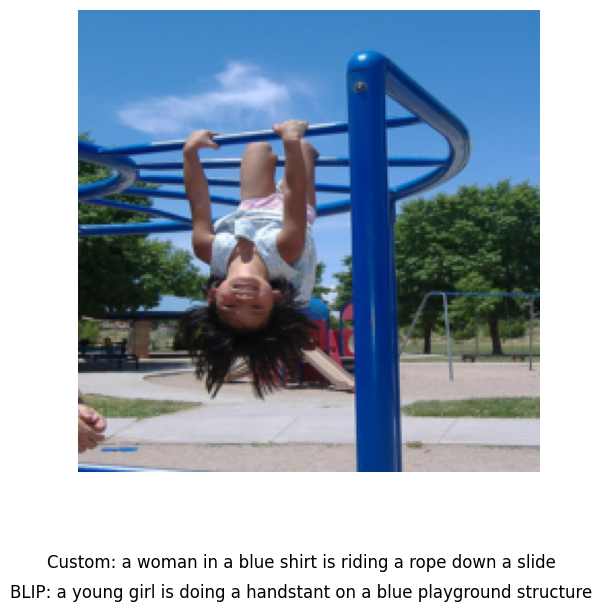

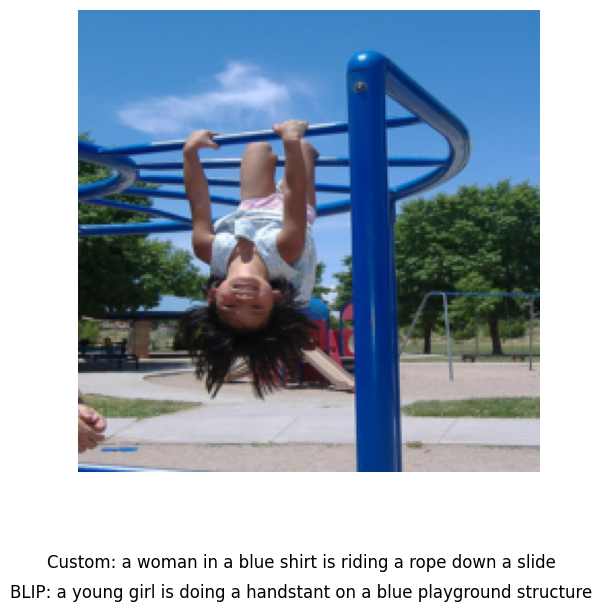

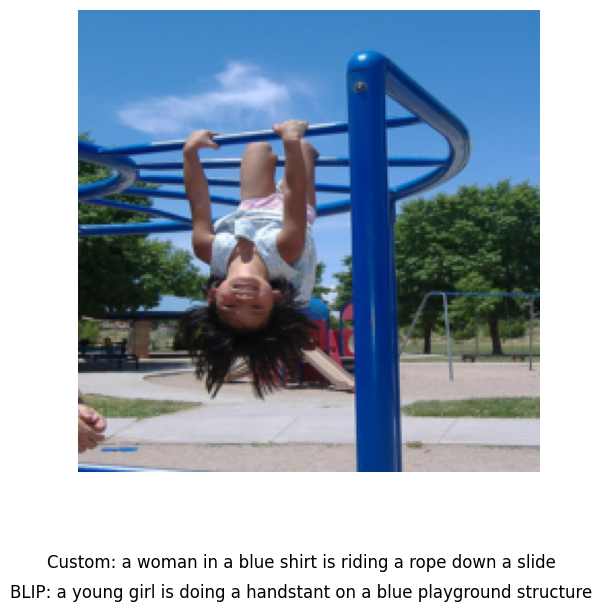

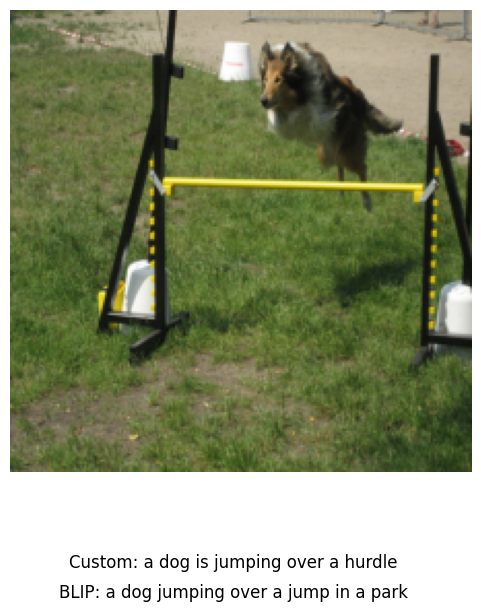

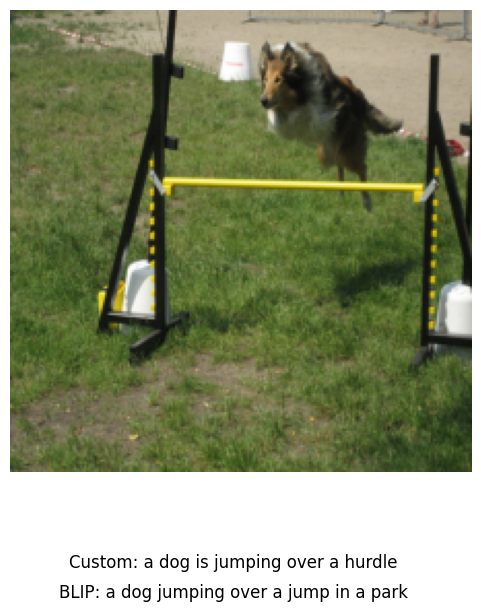

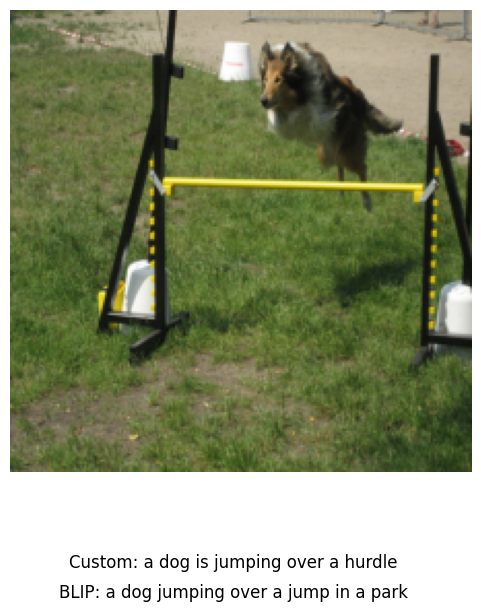

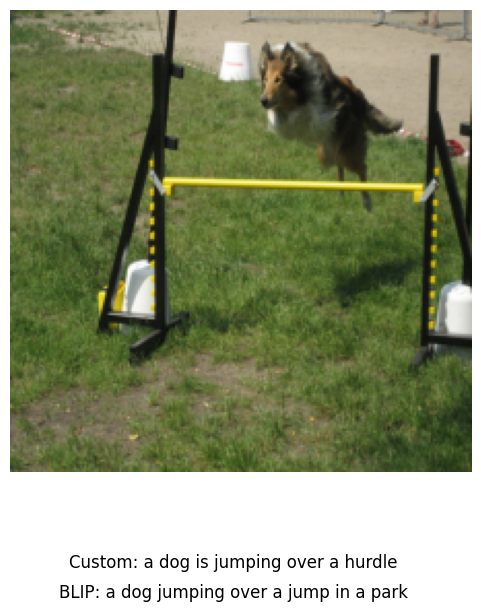

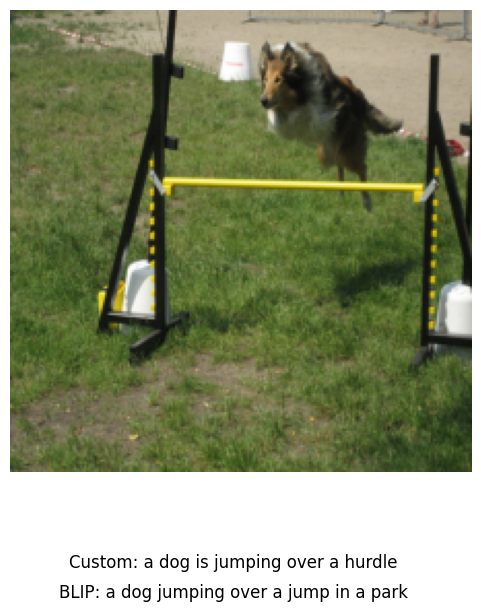

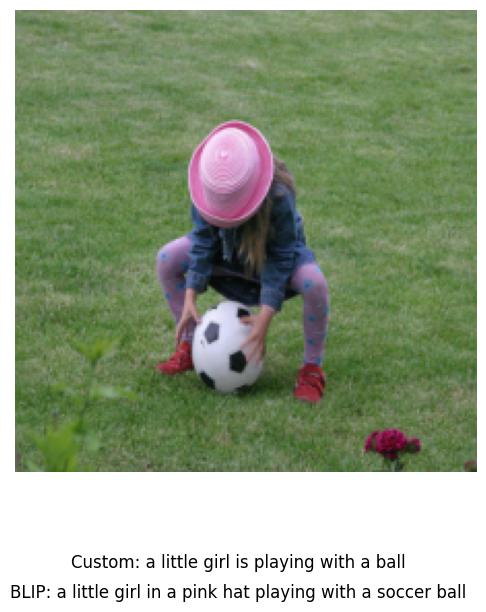

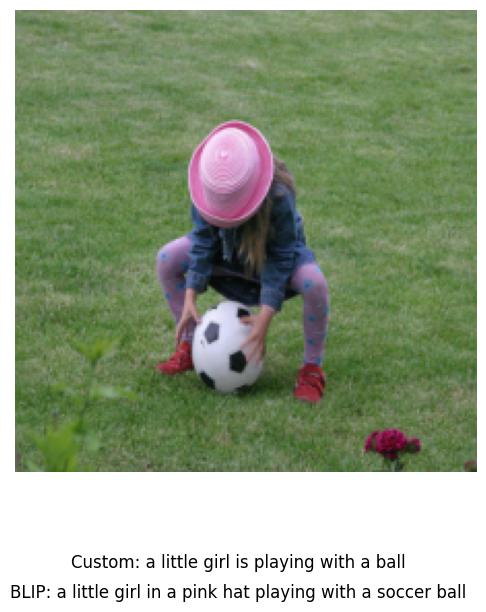

In [11]:
import torch
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
from torchvision import transforms

# Function to visualize predictions with your custom attention-based model and BLIP model
def visualize_predictions(model, test_loader, vocab, device, num_samples=10, max_length=20):

    # Load the pre-trained BLIP model
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    Blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

    # Define the unnormalize transform
    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    # Track how many samples have been processed
    samples_processed = 0

    for images, captions, _ in test_loader:
        if samples_processed >= num_samples:  # Stop if we've reached the required number of samples
            break

        images = images.to(device)
        
        # Loop through each image in the batch
        for i in range(len(images)):
            if samples_processed >= num_samples:  # Stop if we've processed the required number of samples
                break

            # Unnormalize the image
            image_tensor = images[i].cpu()
            image_tensor = unnormalize(image_tensor)
            image_tensor = torch.clamp(image_tensor, 0, 1)  # Clip values to be in the valid range [0, 1]

            image = transforms.ToPILImage()(image_tensor)

            # Generate caption using your custom model with attention
            generated_caption, _ = generate_caption(model, images[i], vocab, device, max_length)
            # Filter out the <SOS> and <EOS> tokens
            filtered_caption = [word for word in generated_caption if word not in {"<SOS>", "<EOS>", "<UNK>"}]
            custom_caption_str = " ".join(filtered_caption)

            # Generate caption using the BLIP model
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = Blip_model.generate(**inputs)
            blip_caption = processor.decode(outputs[0], skip_special_tokens=True)

            
            # Display image with custom and BLIP captions below the image
            plt.figure(figsize=(6, 6))
            plt.imshow(image)
            plt.axis('off')

            # Display both captions at the bottom of the image
            plt.figtext(0.5, -0.05, f"Custom: {custom_caption_str}", wrap=True, horizontalalignment='center', fontsize=12)
            plt.figtext(0.5, -0.10, f"BLIP: {blip_caption}", wrap=True, horizontalalignment='center', fontsize=12)
            
            
            plt.show()

            samples_processed += 1  # Increment the counter after processing each sample

# Ensure vocab is correctly passed from the dataset
vocab = dataset.__dict__ 
visualize_predictions(model, test_loader, vocab, device)
